In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from numpy import ndarray

SKINS_DIR = '../skins/'
FACES_DIR = '../faces/'

In [2]:
def read_face_file(file_name: str) -> ndarray:
    return mpimg.imread(os.path.join(FACES_DIR, file_name))

def read_skin_file(file_name: str) -> ndarray:
    return mpimg.imread(os.path.join(SKINS_DIR, file_name))

## rename all files to zero-padded 5 digits

In [4]:
import os

skin_files = os.listdir(SKINS_DIR)
skin_files = sorted(skin_files)

for i, skin_file_name in enumerate(skin_files):
    new_file_name = "{:05d}".format(i + 1)
    
    file_path = os.path.join(SKINS_DIR, skin_file_name)
    
    _, extension = os.path.splitext(skin_file_name)
    
    new_file_path = os.path.join(SKINS_DIR, new_file_name + extension)
    
    os.rename(file_path, new_file_path)


## show mask and face

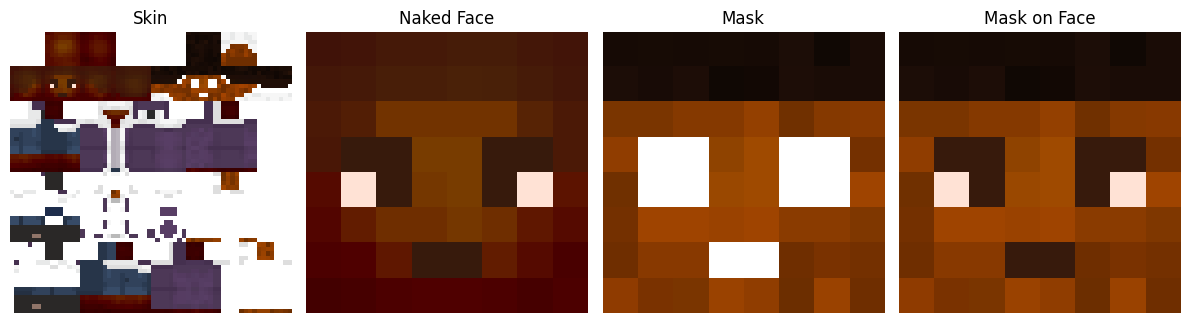

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# source image: https://www.minecraftskins.com/skin/21856799/trial-boy/
skin = mpimg.imread("./trial-boy-21856799.png")

# skin image
axs[0].imshow(skin)
axs[0].set_title('Skin')
axs[0].axis('off')

# naked face
face = skin[8:16, 8:16]
axs[1].imshow(face)
axs[1].set_title('Naked Face')
axs[1].axis('off')

# mask
mask = skin[8:16, 40:48]
axs[2].imshow(mask)
axs[2].set_title('Mask')
axs[2].axis('off')

# mask on face
new_face = face.copy()
opacity = mask[:, :, 3]
non_zero_opacity_indices = np.where(opacity != 0)
new_face[non_zero_opacity_indices] = mask[non_zero_opacity_indices]
axs[3].imshow(new_face)
axs[3].set_title('Mask on Face')
axs[3].axis('off')

plt.tight_layout()
plt.show()

## put mask on face and replace with skin

In [5]:
if not os.path.isdir(FACES_DIR):
    os.mkdir(FACES_DIR)

skin_files = os.listdir(SKINS_DIR)

for skin_file in skin_files:
    skin = read_skin_file(skin_file)
    face = skin[8:16, 8:16]
    mask = skin[8:16, 40:48]

    # put mask on face
    non_zero_opacity_indexes = np.where(mask[:, :, 3] != 0)
    face[non_zero_opacity_indexes] = mask[non_zero_opacity_indexes]

    # save as RGB
    face = Image.fromarray((face[:, :, :3] * 255).astype(np.uint8))
    face.save(os.path.join(FACES_DIR, skin_file))


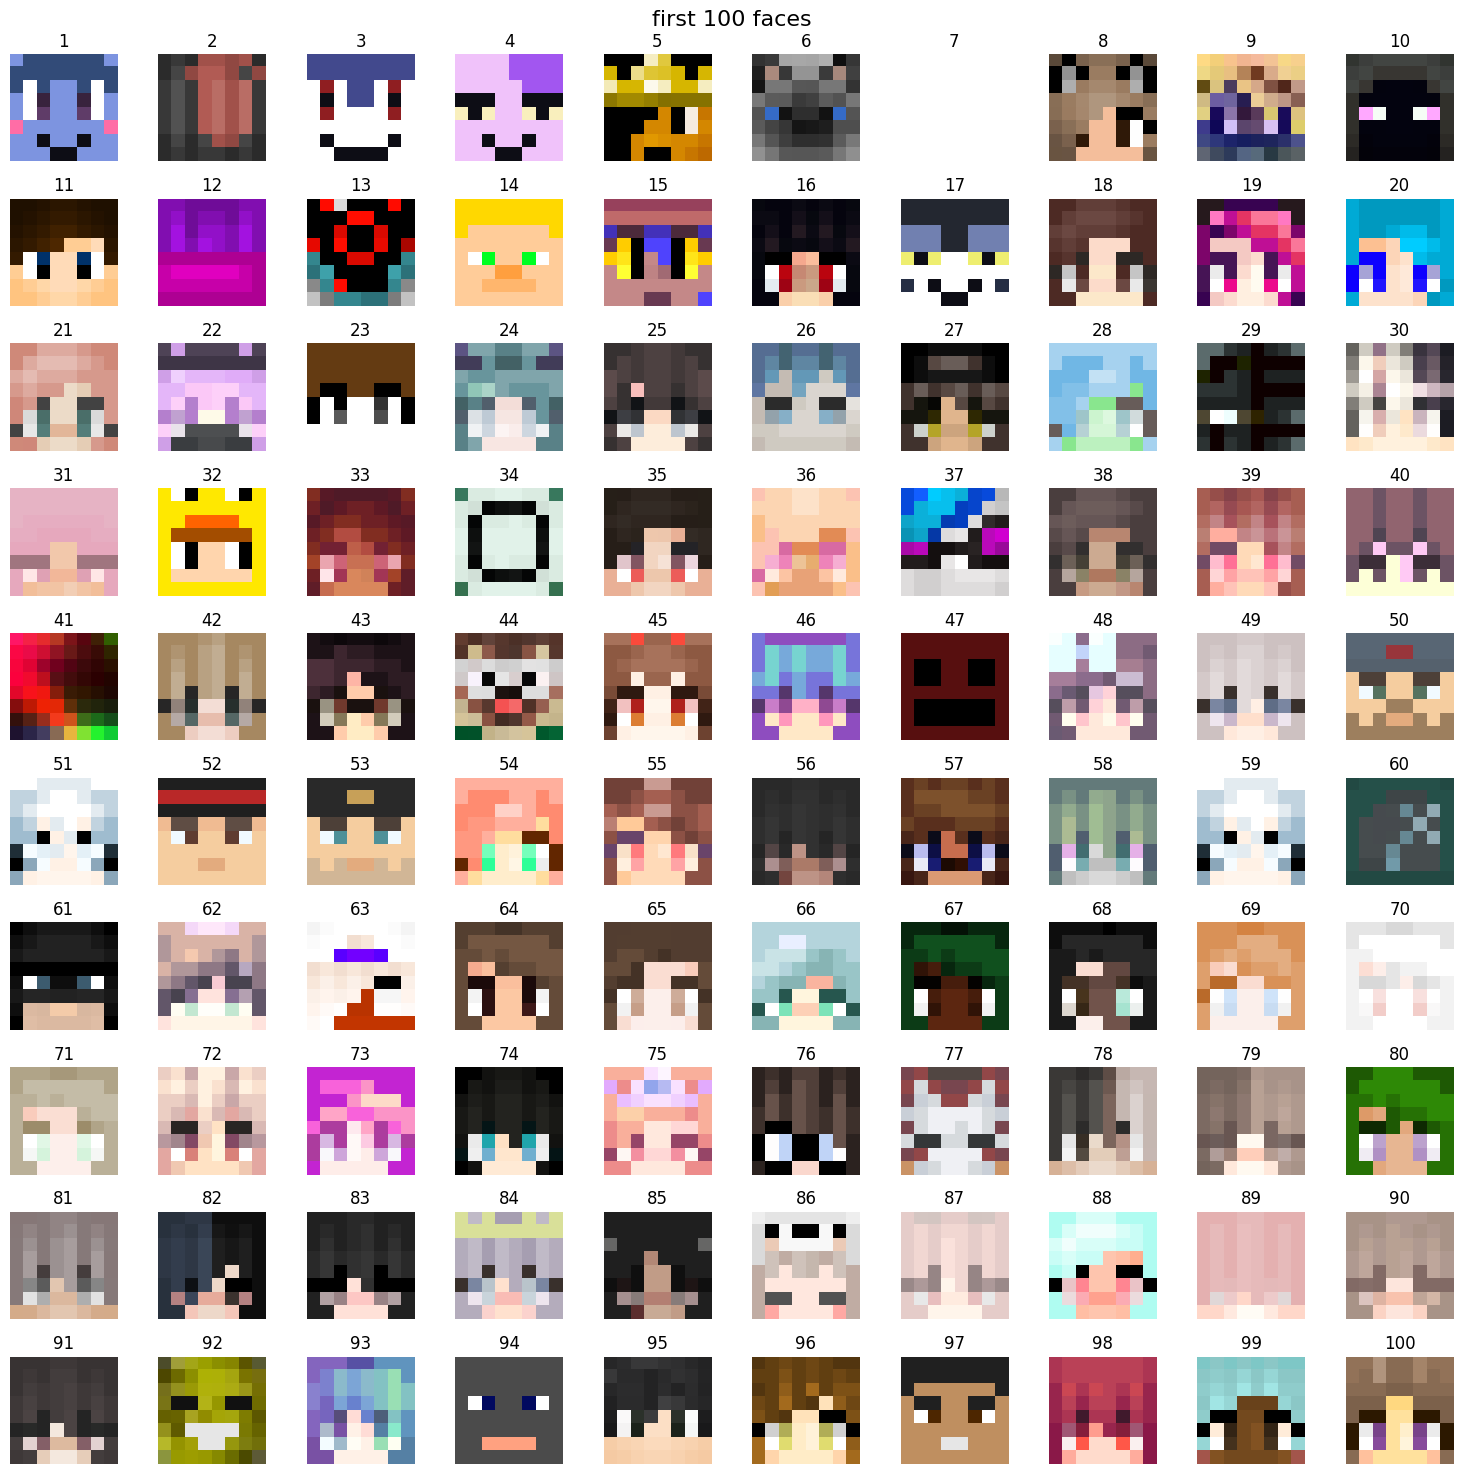

In [7]:
num_faces = 100
face_files = os.listdir(FACES_DIR)
face_files = sorted(face_files)

fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 15))
fig.suptitle(f'first {num_faces} faces', fontsize=16)

for i, face_file in enumerate(face_files[:num_faces]):
    img = read_face_file(face_file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title(str(i + 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## feature selection to detect quality avatars

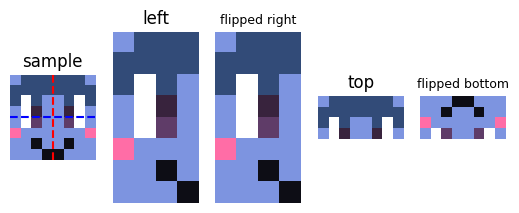

In [8]:
sample = read_face_file('00001.png')

left = sample[:, :4]
right = np.flip(sample[:, 4:], axis=1)
top = sample[:4]
bottom = np.flip(sample[4:], axis=0)

fig, axs = plt.subplots(1, 5)
axs[0].imshow(sample)
axs[0].set_title('sample')
axs[0].axis('off')
axs[0].axvline(x=3.5, color='red', linestyle='--')
axs[0].axhline(y=3.5, color='blue', linestyle='--')

axs[1].imshow(left)
axs[1].set_title('left')
axs[1].axis('off')

axs[2].imshow(right)
axs[2].set_title('flipped right', fontsize=9)
axs[2].axis('off')

axs[3].imshow(top)
axs[3].set_title('top')
axs[3].axis('off')

axs[4].imshow(bottom)
axs[4].set_title('flipped bottom', fontsize=9)
axs[4].axis('off')

plt.show()

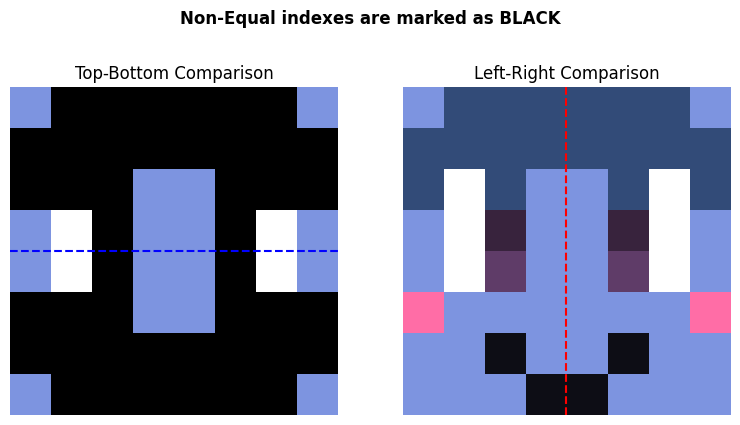

In [9]:
equal_pixels_tb = np.all(top == bottom, axis=2)
tb_compare = np.zeros_like(sample)
tb_compare[:4] = np.where(equal_pixels_tb[:, :, np.newaxis], top, 0)
tb_compare[4:] = np.where(equal_pixels_tb[:, :, np.newaxis], bottom, 0)
tb_compare[4:] = np.flip(tb_compare[4:], axis=0)


equal_pixels_lr = np.all(left == right, axis=2)
lr_compare = np.zeros_like(sample)
lr_compare[:, :4] = np.where(equal_pixels_lr[:, :, np.newaxis], left, 0)
lr_compare[:, 4:] = np.where(equal_pixels_lr[:, :, np.newaxis], right, 0)
lr_compare[:, 4:] = np.flip(lr_compare[:, 4:], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Non-Equal indexes are marked as BLACK', fontsize=12, fontweight='bold', y=1.05)

axs[0].imshow(tb_compare)
axs[0].axhline(y=3.5, color='blue', linestyle='--')
axs[0].set_title('Top-Bottom Comparison')
axs[0].axis('off')

axs[1].imshow(lr_compare)
axs[1].axvline(x=3.5, color='red', linestyle='--')
axs[1].set_title('Left-Right Comparison')
axs[1].axis('off')

plt.tight_layout()
plt.show()

top-down and right-left symmetricity rate features

In [10]:
def calculate_tb_sym_rate(img: ndarray):
    top = img[:4]
    bottom = np.flip(img[4:], axis=0)
    tb_sym_count = (top == bottom).all(axis=2)
    return tb_sym_count.sum() / np.prod(tb_sym_count.shape)

def calculate_rl_sym_rate(img: ndarray):
    left = img[:, :4]
    right = np.flip(img[:, 4:], axis=1)
    rl_sym_count = (right == left).all(axis=2)
    return rl_sym_count.sum() / np.prod(rl_sym_count.shape)

color count feature

In [11]:
def calculate_num_colors(img: ndarray):
    pixels = img.reshape(-1, 3)
    return len(np.unique(pixels, axis=0))

make DataFrame

In [27]:
import pandas as pd

df = pd.DataFrame(columns=['file_name', 'rl_sym_rate', 'tb_sym_rate', 'num_colors'])

for face_file in face_files:
    img = read_face_file(face_file)

    tb_sym_rate = calculate_tb_sym_rate(img)

    rl_sym_rate = calculate_rl_sym_rate(img)

    num_colors = calculate_num_colors(img)

    df.loc[len(df)] = [face_file, rl_sym_rate, tb_sym_rate, num_colors]

df.sample(5)

,file_name,rl_sym_rate,tb_sym_rate,num_colors
3642,03643.png,0.78125,0.1250,8
33,00034.png,0.87500,0.7500,8
3033,03034.png,0.62500,0.6250,15
2041,02042.png,0.96875,0.1875,9
904,00905.png,0.93750,0.3125,8


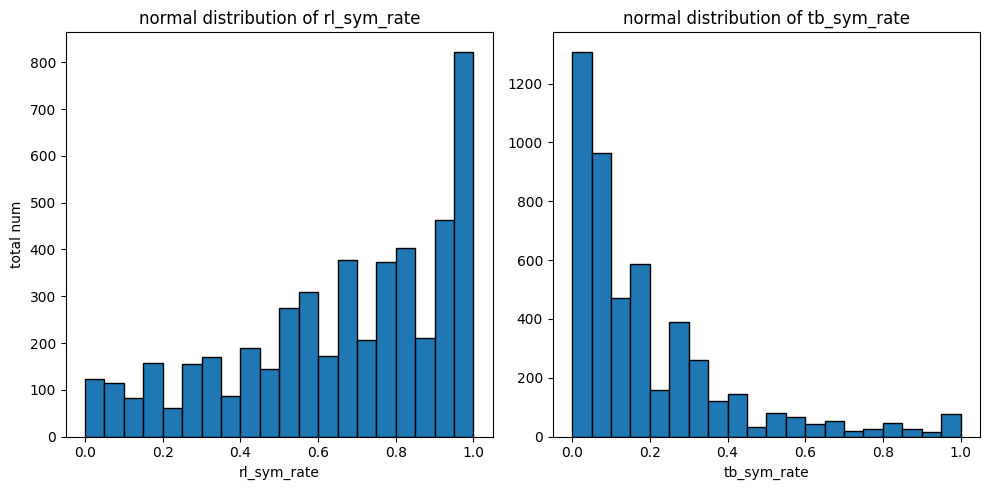

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# normal distribution of rl_sym_rate
axs[0].hist(df['rl_sym_rate'], bins=20, edgecolor='black')
axs[0].set_xlabel('rl_sym_rate')
axs[0].set_ylabel('total num')
axs[0].set_title('normal distribution of rl_sym_rate')

# normal distribution of tb_sym_rate
axs[1].hist(df['tb_sym_rate'], bins=20, edgecolor='black')
axs[1].set_xlabel('tb_sym_rate')
axs[1].set_title('normal distribution of tb_sym_rate')

plt.tight_layout()
plt.show()

## manually label 150 random images

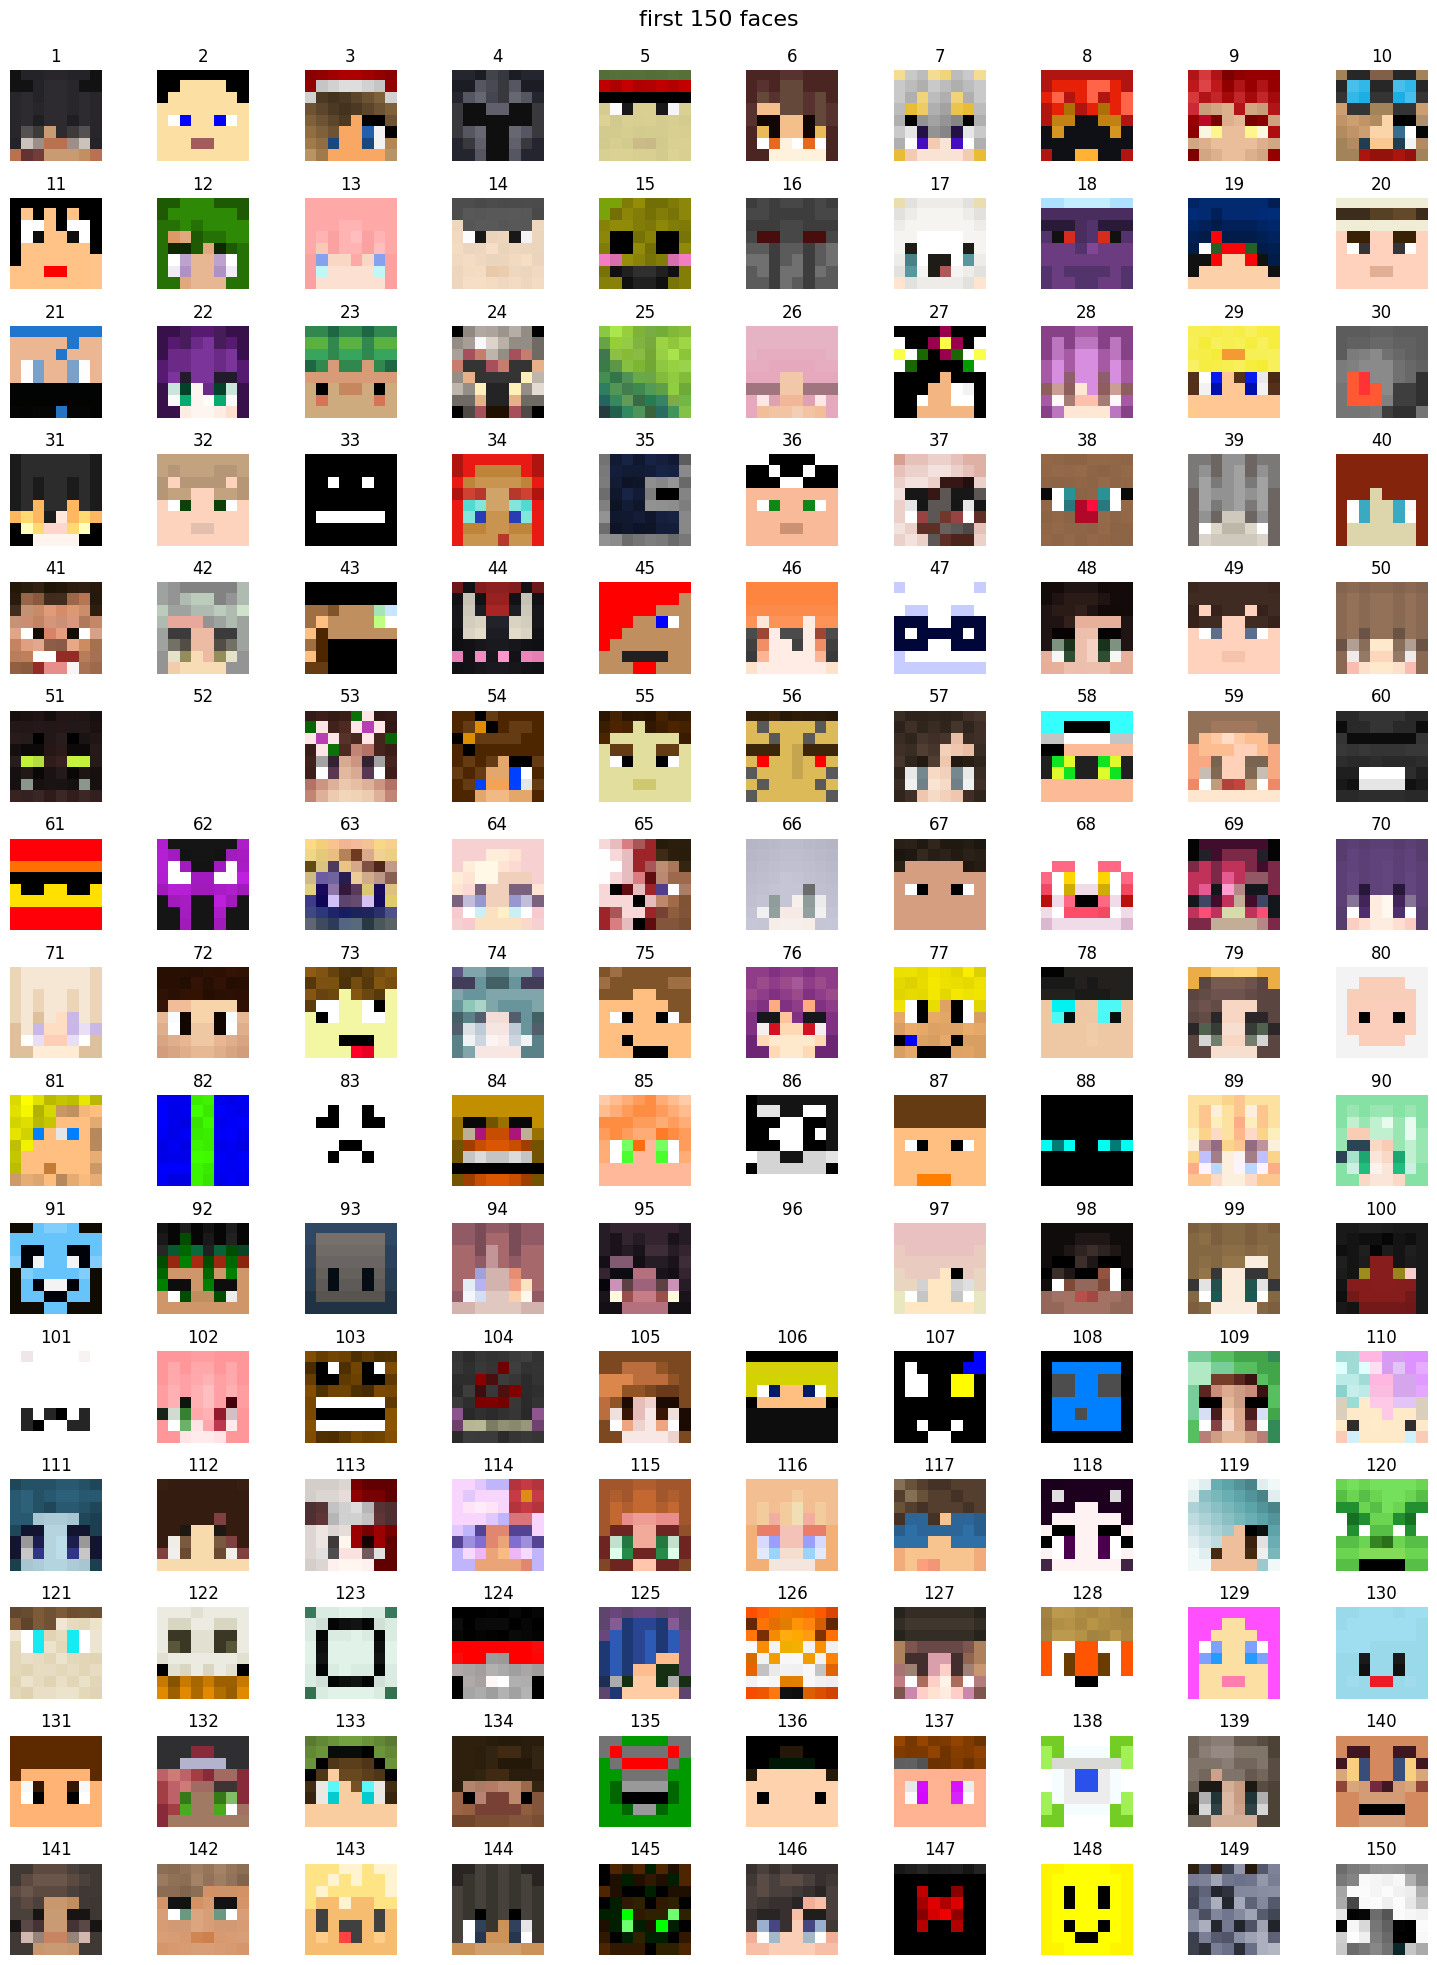

In [666]:
sample = df.sample(n = 300, random_state=42)

num_faces = 150

fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 20))
fig.suptitle(f'first {num_faces} faces', fontsize=16)

for i, face_file in enumerate(sample['file_name'][:150]):
    img = read_face_file(face_file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title(str(i + 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

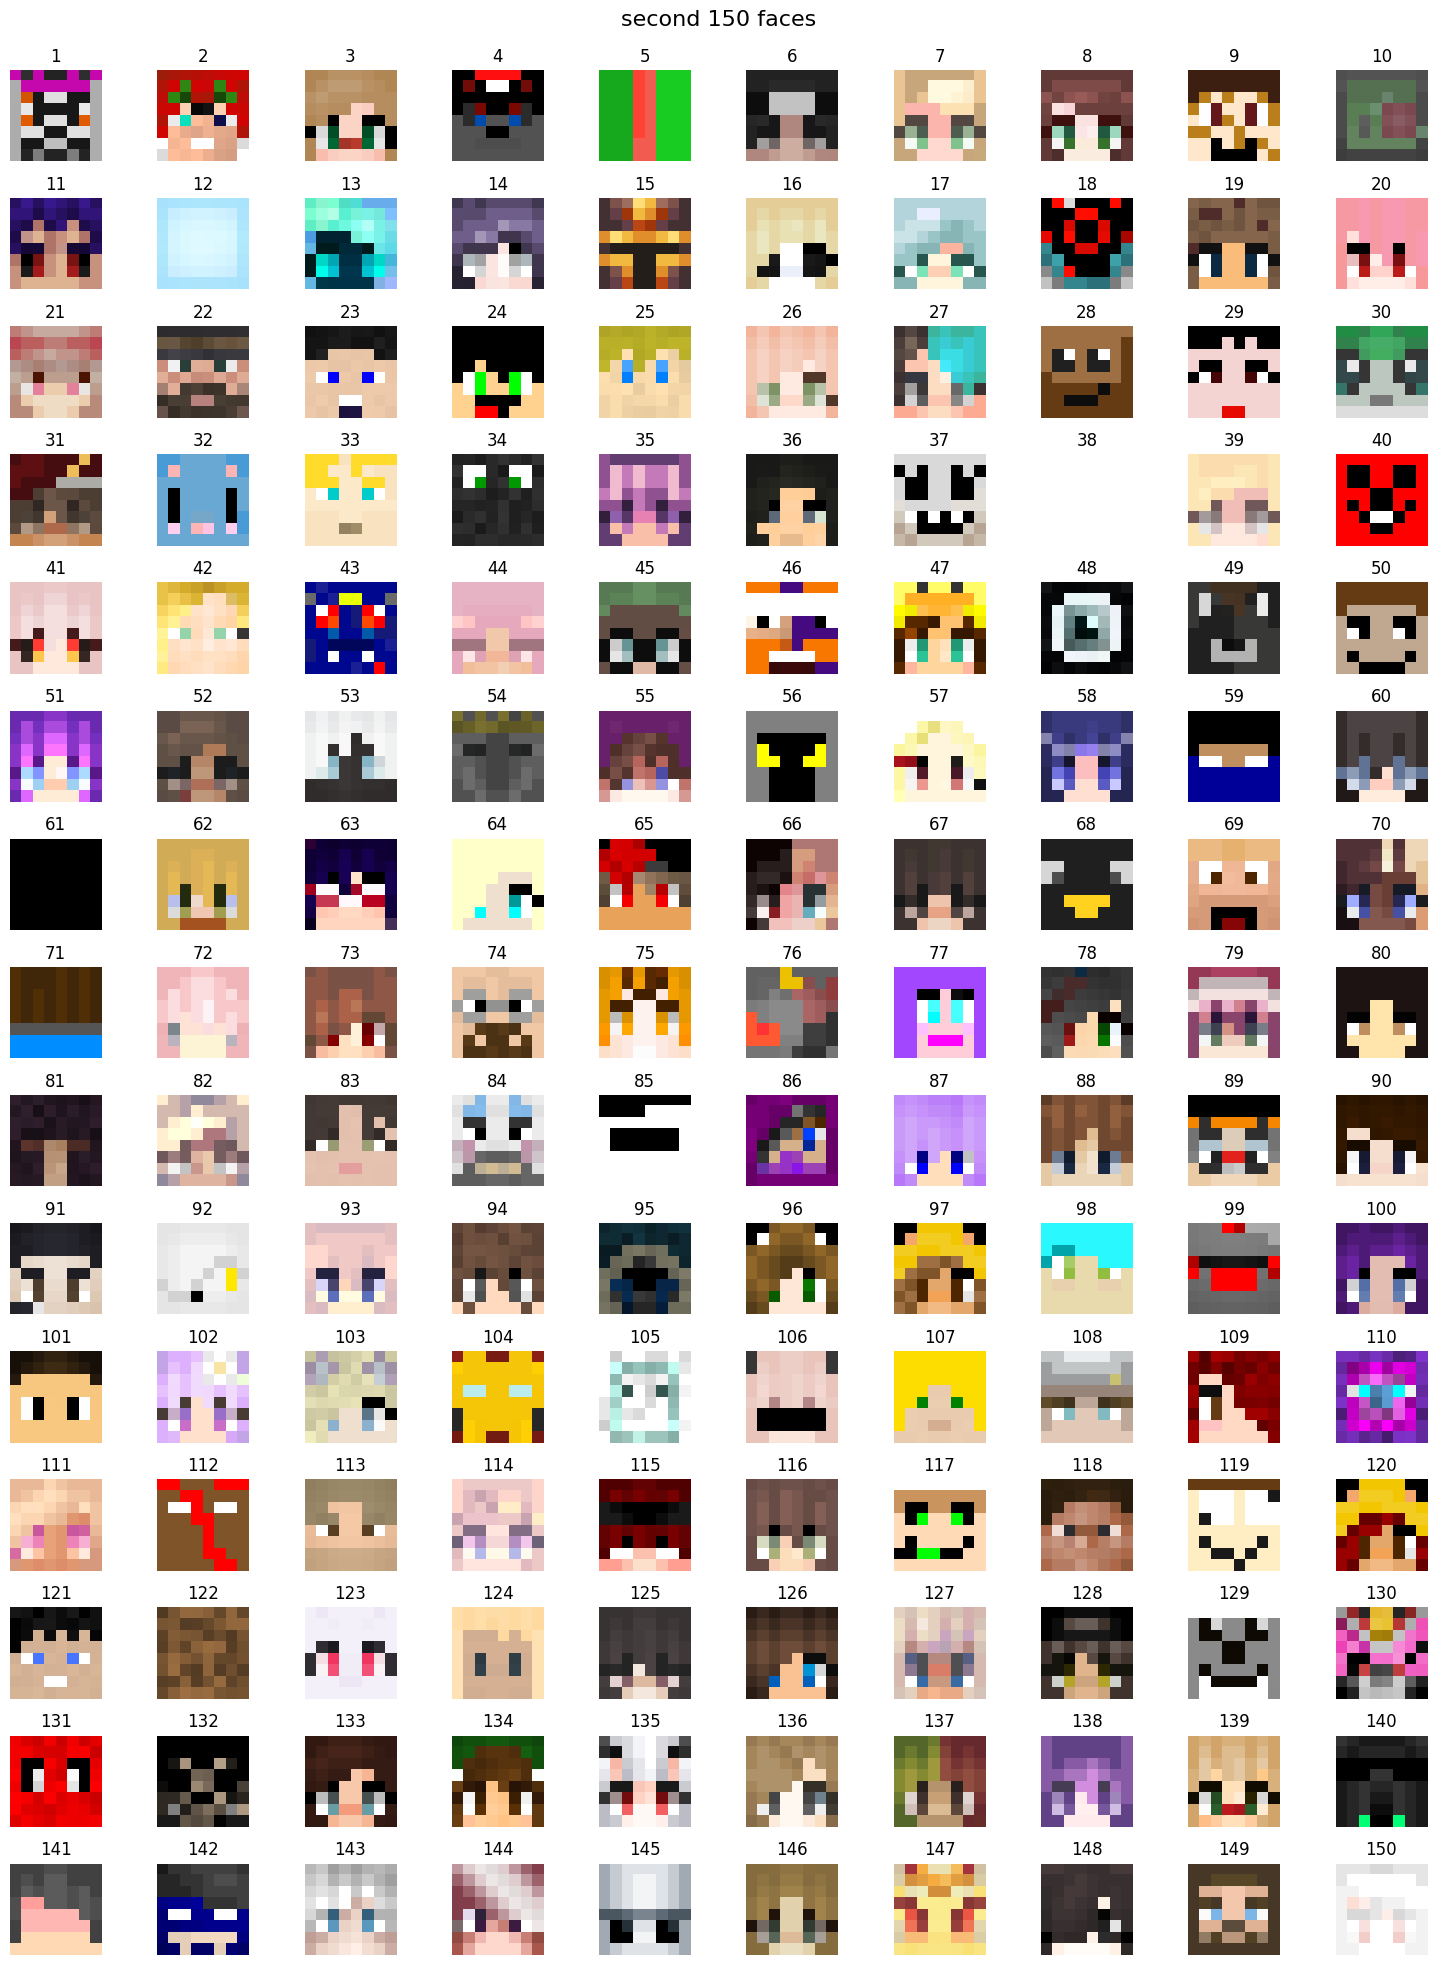

In [667]:
fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 20))
fig.suptitle(f'second {num_faces} faces', fontsize=16)

for i, face_file in enumerate(sample['file_name'][150:300]):
    img = read_face_file(face_file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title(str(i + 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [668]:
sample['is_valid'] = [
    1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
    0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0
]

print(f'ratio: {sample["is_valid"].sum() / len(sample)}')

ratio: 0.6133333333333333


## Train a model

In [669]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### data preparation

In [670]:
def load_images(image_paths):
    loaded_images = []
    for path in image_paths:
        image = Image.open(os.path.join(FACES_DIR, path))
        loaded_images.append(image)

    image_arrays = [np.array(image) for image in loaded_images]
    image_array = np.array(image_arrays)

    return image_array


X = sample.drop(columns=['is_valid', 'file_name'], axis=1).to_numpy()
X_img = load_images(sample['file_name'])
y = sample['is_valid'].to_numpy()


normalization

In [672]:
def normalize_X(X):
    scaler = StandardScaler().fit(X)
    return scaler.transform(X)

def normalize_X_img(X_img):
    return X_img / 255

X = normalize_X(X)
X_img = normalize_X_img(X_img)

### convolutional model

build model

In [673]:
conv_model = Sequential([
    Conv2D(32, kernel_size=(2, 2), activation='relu',
           input_shape=(8, 8, 3),
           kernel_regularizer='l2'),
    Dropout(0.5),
    
    Conv2D(16, kernel_size=(3, 3), activation='relu',
           kernel_regularizer='l2'),
    Dropout(0.3),

    Conv2D(8, kernel_size=(4, 4), activation='relu',
           kernel_regularizer='l2'),
    Dropout(0.2),
    Flatten(),
    
    Dense(5, activation='linear')
])


train

In [674]:
conv_model.compile(optimizer=Adam(learning_rate=0.005),
                   loss=MeanSquaredError())

In [675]:
conv_hist = conv_model.fit(X_img, y,
                           epochs=200, batch_size=32, verbose=0)

print('MSE loss:')
for i, loss in enumerate(conv_hist.history['loss']):
    if (i + 1) % 10 == 0:
        print(f'{i+1:3d}) {loss:.4f}', end='\t')

        if (i + 1) % 50 == 0:
            print()

MSE loss:
 10) 0.2558	 20) 0.2137	 30) 0.2025	 40) 0.2073	 50) 0.1937	
 60) 0.1952	 70) 0.1823	 80) 0.1898	 90) 0.1813	100) 0.1887	
110) 0.2000	120) 0.1825	130) 0.2033	140) 0.1869	150) 0.1829	
160) 0.1787	170) 0.1775	180) 0.1860	190) 0.1871	200) 0.1850	


save model

In [595]:
conv_model.save('conv_model.keras')

### XGBoost

In [693]:
import xgboost as xgb

conv_features = conv_model.predict(X_img)
features = np.c_[conv_features, X]

10/10 [==============================] - 0s 2ms/step


In [694]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [695]:
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=100,
                              learning_rate=0.001,
                              early_stopping_rounds=50)
xgb_hist = xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

In [696]:
history = xgb_hist.evals_result()

# Print the loss at each 10th step
print('validation log loss')
for i, loss in enumerate(history['validation_1']['logloss']):
    if (i + 1) % 10 == 0:
        print(f'{i+1:3d}) {loss:.4f}', end='\t')

        if (i + 1) % 50 == 0:
            print()


validation log loss
 10) 0.6890	 20) 0.6849	 30) 0.6809	 40) 0.6770	 50) 0.6731	
 60) 0.6694	 70) 0.6657	 80) 0.6621	 90) 0.6585	100) 0.6551	


In [697]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.33%


In [598]:
xgb_model.save_model('xgb_model.bin')

## test inference

In [698]:
test_sample = df.sample(100, random_state=142)

In [699]:
test_X = test_sample.drop(columns=['file_name'], axis=1).to_numpy()
test_X_img = load_images(test_sample['file_name'])

normalization

In [700]:
test_X = normalize_X(test_X)
test_X_img = normalize_X_img(test_X_img)

In [701]:
text_xgb_input = np.c_[conv_model.predict(test_X_img), test_X]

4/4 [==============================] - 0s 2ms/step


In [702]:
test_y_pred = xgb_model.predict(text_xgb_input)

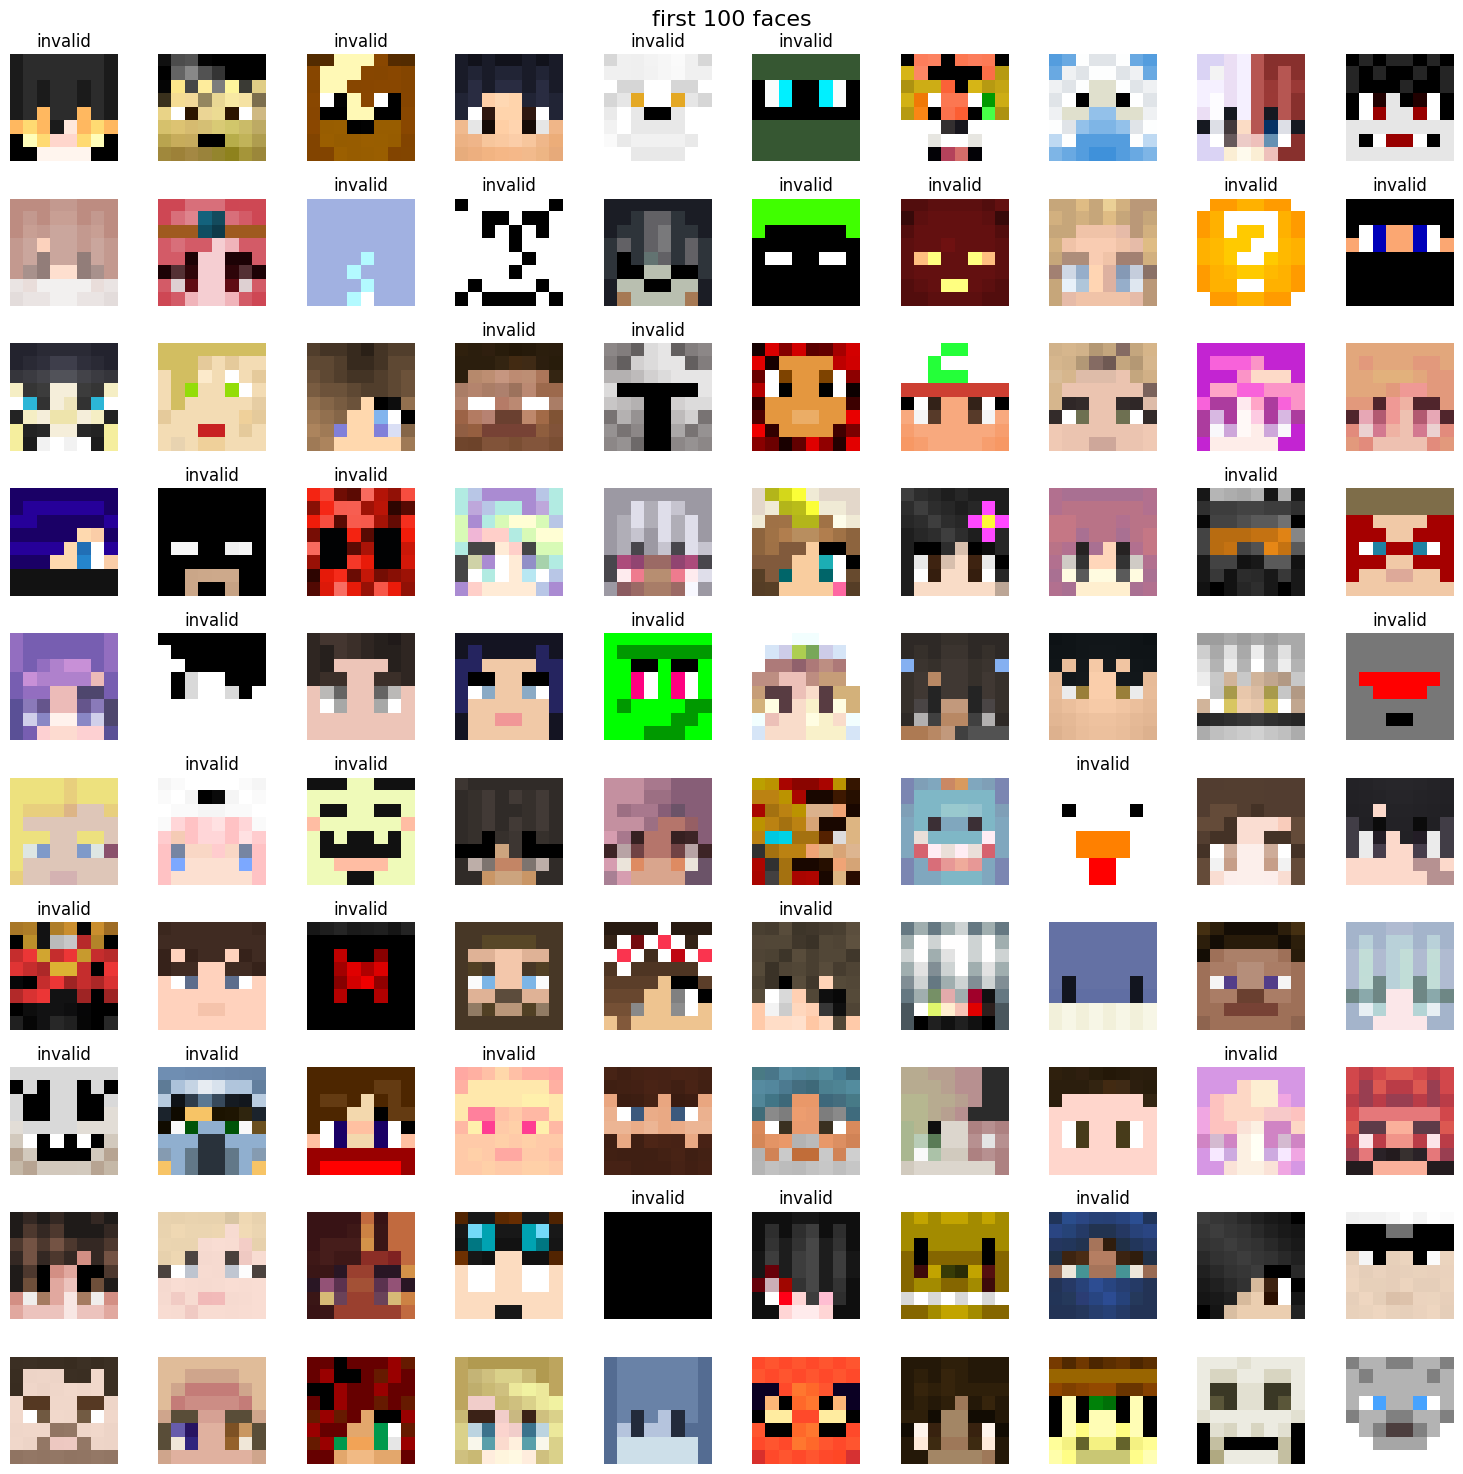

In [703]:
num_faces = 100

fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 15))
fig.suptitle(f'first {num_faces} faces', fontsize=16)

for i, face_file in enumerate(test_sample['file_name'][:num_faces]):
    img = read_face_file(face_file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title('invalid' if test_y_pred[i] == 0 else '')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()